In [7]:
!pip install ultralytics easyocr pandas matplotlib opencv-python-headless

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl (11.0 MB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)
Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)

   ---------------------------------------- 0/5 [opencv-python-headless]



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'E:\\Zindi\\smart parking\\venv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip install pandas --upgrade

  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl (11.0 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import cv2
import easyocr


# Load YOLOv8 model for license plate detection
model = YOLO('trained_license_plate_detector.pt')

# Parking Manager Class
class ParkingManager:
    def __init__(self, csv_path='parking_records.csv'):
        self.csv_path = csv_path
        self.reader = easyocr.Reader(['en'])  # Initialize OCR for English
        
        # Create or load the CSV file
        try:
            self.df = pd.read_csv(csv_path)
        except FileNotFoundError:
            self.df = pd.DataFrame(columns=[
                'timestamp', 'license_plate', 'confidence',
                'vehicle_image', 'entry_time'
            ])
            self.save_records()
    
    def preprocess_plate_image(self, img):
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Enhance contrast
        img = cv2.equalizeHist(img)
        
        # Resize for better OCR
        img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        
        return img
    
    def read_license_plate(self, image, bbox):
        try:
            x, y, w, h = map(int, bbox)
            # Extract plate region
            plate_img = image[y:y+h, x:x+w]
            
            # Preprocess the image
            processed_img = self.preprocess_plate_image(plate_img)
            
            # Perform OCR
            results = self.reader.readtext(processed_img)
            
            if results:
                # Get the text with highest confidence
                text, conf = max(results, key=lambda x: x[2])[1:3]
                # Clean the text (remove spaces and special characters)
                text = ''.join(c for c in text if c.isalnum()).upper()
                return text, conf
            
            return None, 0.0
            
        except Exception as e:
            print(f"Error reading license plate: {e}")
            return None, 0.0
    
    def add_parking_record(self, license_plate, confidence, vehicle_image):
        # Add new record
        new_record = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'license_plate': license_plate,
            'confidence': confidence,
            'vehicle_image': vehicle_image,
            'entry_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        self.df = pd.concat([self.df, pd.DataFrame([new_record])], ignore_index=True)
        self.save_records()
        print(f"Added parking record for: {license_plate}")
    
    def save_records(self):
        self.df.to_csv(self.csv_path, index=False)
    
    def get_records(self):
        return self.df

# Initialize parking manager
parking_manager = ParkingManager()

# Function to detect and read license plates from an image
def detect_and_read_plate(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
        return
    
    # Detect license plates
    results = model.predict(image_path, conf=0.25)
    
    if not results:
        print("No license plates detected")
        return
    
    result = results[0]
    plates_found = False
    
    # Create a copy for visualization
    display_img = image.copy()
    
    # Process each detection
    for box in result.boxes:
        # Get box coordinates
        bbox = box.xyxy[0].cpu().numpy()  # get box coordinates in (top, left, bottom, right) format
        conf = float(box.conf[0])
        
        # Convert bbox format from (x1,y1,x2,y2) to (x,y,w,h)
        x1, y1, x2, y2 = map(int, bbox)
        bbox_xywh = [x1, y1, x2-x1, y2-y1]
        
        # Read the license plate text
        plate_text, ocr_conf = parking_manager.read_license_plate(image, bbox_xywh)
        
        if plate_text:
            plates_found = True
            # Add to parking records
            parking_manager.add_parking_record(plate_text, ocr_conf * conf, os.path.basename(image_path))
            
            # Draw on image
            cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(display_img, f"{plate_text} ({ocr_conf:.2f})",
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                       0.9, (0, 255, 0), 2)
    
    # Display results
    if plates_found:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('License Plate Detection and OCR')
        plt.show()
        
        # Display parking records
        print("\nCurrent Parking Records:")
        print(parking_manager.get_records())


# Test the license plate detection and OCR system
print("Testing license plate detection and OCR system...")

# Test with sample image
sample_image = 'kenya car.jpg'
detect_and_read_plate(sample_image)

# Display all parking records
print("\nAll parking records:")
print(parking_manager.get_records())

ModuleNotFoundError: No module named 'pandas'

In [1]:
#@title Import Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import numpy as np


In [3]:
# Function to load COCO annotations and create a DataFrame
def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Create DataFrames for images and annotations
    images_df = pd.DataFrame(coco_data['images'])
    annotations_df = pd.DataFrame(coco_data['annotations'])

    # Merge image and annotation information
    df = pd.merge(images_df, annotations_df, left_on='id', right_on='image_id')

    return df, coco_data

# Load annotations for each set
train_df, train_coco = load_coco_annotations('train/_annotations.coco.json')
test_df, test_coco = load_coco_annotations('test/_annotations.coco.json')
valid_df, valid_coco = load_coco_annotations('valid/_annotations.coco.json')

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", valid_df.shape)

Train set shape: (7357, 14)
Test set shape: (1085, 14)
Validation set shape: (2195, 14)


Visualizing image from train: xemay1711_jpg.rf.6d4a4924f2611e77dbe6021b7c38f0d6.jpg


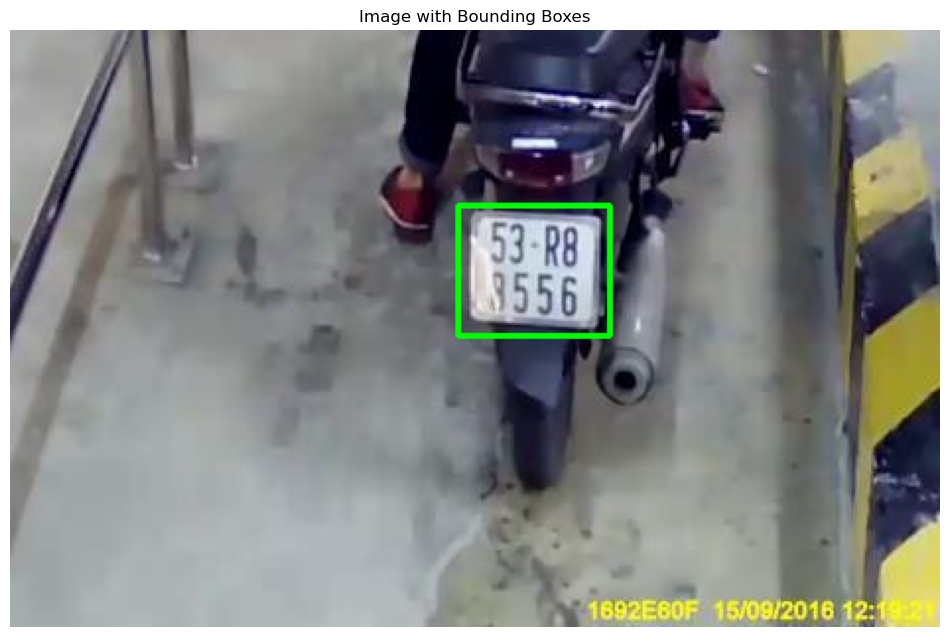

Visualizing image from test: CarLongPlate405_jpg.rf.9902290faf3358ce6aa9d373270fb635.jpg


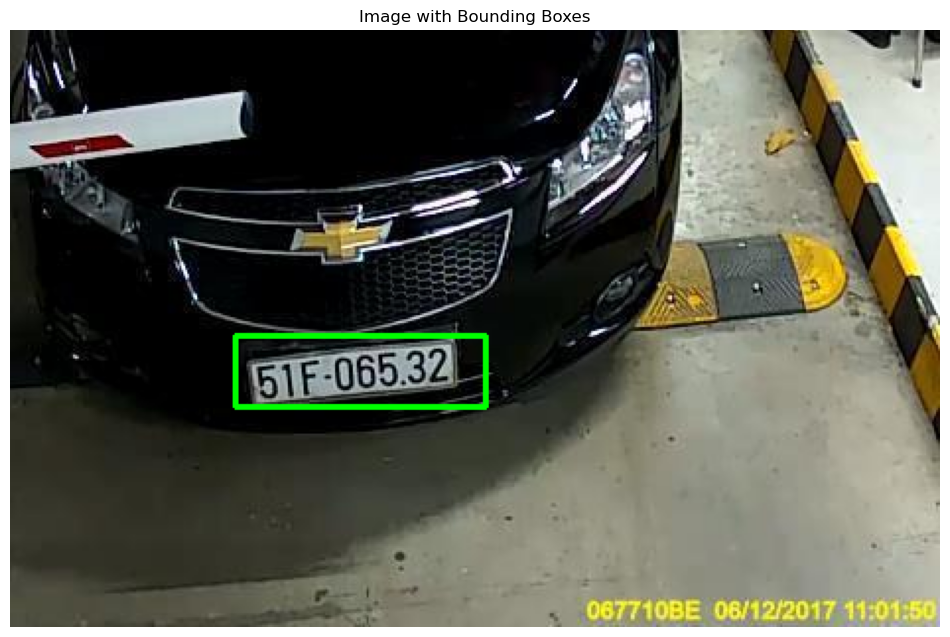

Visualizing image from valid: xemay297_jpg.rf.de6b456fa7dadf0d5c07a58dcc63474c.jpg


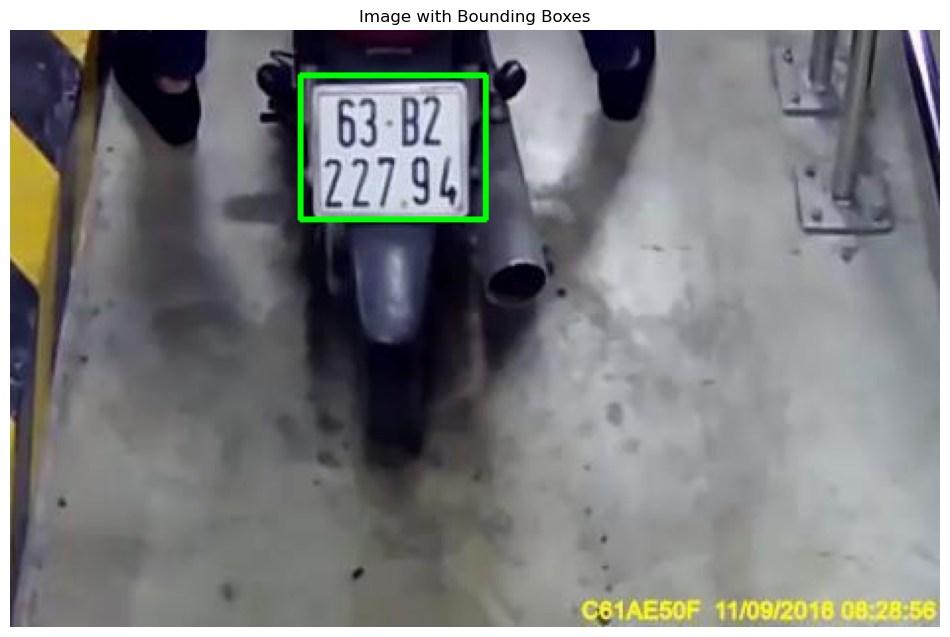

In [4]:
# Function to visualize image with bounding boxes
def visualize_image_with_bbox(image_path, annotations):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(coord) for coord in bbox]

        # Draw rectangle
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image with Bounding Boxes')
    plt.show()

# Visualize one example from each set
def visualize_example(df, coco_data, folder):
    # Get first image info
    example = df.iloc[0]
    image_filename = example['file_name']
    image_id = example['image_id']

    # Get all annotations for this image
    image_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

    # Visualize
    image_path = os.path.join(folder, image_filename)
    print(f"Visualizing image from {folder}: {image_filename}")
    visualize_image_with_bbox(image_path, image_anns)

# Visualize examples from each set
visualize_example(train_df, train_coco, 'train')
visualize_example(test_df, test_coco, 'test')
visualize_example(valid_df, valid_coco, 'valid')

# Training YOLOv8 Model for License Plate Detection

We'll use YOLOv8n (nano) model for our license plate detection task. The steps will be:
1. Install and import required packages
2. Prepare the data in YOLOv8 format
3. Configure and train the model
4. Test the model on images and video

In [ ]:
%%capture
!pip install ultralytics

In [2]:
# Install required packages if not already installed
from ultralytics import YOLO
import yaml
import shutil

# Function to convert COCO annotations to YOLO format
def convert_coco_to_yolo(df, image_folder, output_folder):
    # Create output directories for images and labels
    images_folder = os.path.join(output_folder, 'images')
    labels_folder = os.path.join(output_folder, 'labels')
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)

    # Process each image
    for name, group in df.groupby('file_name'):
        # Get image dimensions
        img_width = group['width'].iloc[0]
        img_height = group['height'].iloc[0]

        # Create YOLO format annotations
        yolo_anns = []
        for _, row in group.iterrows():
            # Get bbox coordinates
            x, y, w, h = row['bbox']

            # Convert to YOLO format (normalized coordinates)
            x_center = (x + w/2) / img_width
            y_center = (y + h/2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height

            # Class id (0 for license plate)
            class_id = 0

            # Add annotation
            yolo_anns.append(f"{class_id} {x_center} {y_center} {w_norm} {h_norm}")

        # Write annotations to file
        base_name = os.path.splitext(name)[0]
        label_path = os.path.join(labels_folder, base_name + '.txt')
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_anns))

        # Copy image to the new location
        src_path = os.path.join(image_folder, name)
        dst_path = os.path.join(images_folder, name)
        shutil.copy2(src_path, dst_path)

In [6]:
# Create YOLO format dataset
print("Converting datasets to YOLO format...")

# Convert each dataset
convert_coco_to_yolo(train_df, 'train', 'yolo_dataset/train')
convert_coco_to_yolo(valid_df, 'valid', 'yolo_dataset/valid')
convert_coco_to_yolo(test_df, 'test', 'yolo_dataset/test')

# Create dataset.yaml file for YOLOv8
dataset_config = {
    'path': os.path.abspath('yolo_dataset'),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': {
        0: 'license_plate'
    }
}

with open('dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f)

print("Dataset preparation completed!")

Converting datasets to YOLO format...


Dataset preparation completed!


In [ ]:
# Initialize and train YOLOv8 model
def train_yolo_model():
    # Load a YOLOv8n model
    model = YOLO('yolov8n.pt')

    # Train the model
    results = model.train(
    data="dataset.yaml",          # Path to data.yaml
    epochs=100,                    # Number of training epochs
    imgsz=640,                     # Image size
    batch=16,                      # Batch size (adjust based on GPU memory)
    name='license_plate_detector', # Experiment name
    patience=5,                   # Early stopping patience
    save=True,                     # Save checkpoints
    plots=True,                    # Generate plots
    device=0,                      # Use GPU 0 (use 'cpu' if no GPU available)
    verbose=True,                  # Verbose output

    # Augmentation parameters
    hsv_h=0.015,                   # Image HSV-Hue augmentation
    hsv_s=0.7,                     # Image HSV-Saturation augmentation
    hsv_v=0.4,                     # Image HSV-Value augmentation
    degrees=0.0,                   # Image rotation (+/- deg)
    translate=0.1,                 # Image translation (+/- fraction)
    scale=0.5,                     # Image scale (+/- gain)
    flipud=0.0,                    # Vertical flip probability
    fliplr=0.5,                    # Horizontal flip probability
    mosaic=1.0,                    # Mosaic augmentation probability
    )

    return model

# Train the model
print("Starting model training...")
model = train_yolo_model()
print("Training completed!")


Starting model training...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=license_plate_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective

In [ ]:
# save the trained model
model.save('trained_license_plate_detector.pt')

In [3]:
model = YOLO('trained_license_plate_detector.pt')
# Function to detect license plates in images
def detect_license_plate(model, image_path):
    # Perform prediction
    results = model.predict(image_path, conf=0.25)

    # Get the first result
    result = results[0]

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.imshow(result.plot())
    plt.axis('off')
    plt.title('License Plate Detection')
    plt.show()

    return results

# Function to detect license plates in video
def detect_license_plates_video(model, video_path):
    results = model.predict(video_path, stream=True)
    return results

# Test the model on a sample image
sample_image = 'test/0039ac4bfb8bd69d_jpg.rf.3ec9086558292883d326962f697d2b2d.jpg'
print("Testing model on a sample image...")
results = detect_license_plate(model, sample_image)

Testing model on a sample image...

image 1/1 e:\Zindi\Smart Parking Management System\test\0039ac4bfb8bd69d_jpg.rf.3ec9086558292883d326962f697d2b2d.jpg: 480x640 1 license_plate, 233.5ms
Speed: 19.8ms preprocess, 233.5ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)


: 

# Smart Parking Management System: License Plate OCR

We'll implement:
1. License plate text extraction using EasyOCR
2. Parking record management with timestamps
3. CSV file storage for parking data

In [15]:
# Install required package
!pip install --user easyocr

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached ninja-1.13.0-py3-none-win_amd64.whl.metadata (5.1 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached ninja-1.13.0-py3-none-win_amd64.whl (309 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)

   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:


class ParkingManager:
    def __init__(self, csv_path='parking_records.csv'):
        self.csv_path = csv_path
        self.reader = easyocr.Reader(['en'])  # Initialize OCR for English
        
        # Create or load the CSV file
        try:
            self.df = pd.read_csv(csv_path)
        except FileNotFoundError:
            self.df = pd.DataFrame(columns=[
                'timestamp', 'license_plate', 'confidence',
                'vehicle_image', 'entry_time'
            ])
            self.save_records()
    
    def preprocess_plate_image(self, img):
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Enhance contrast
        img = cv2.equalizeHist(img)
        
        # Resize for better OCR
        img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        
        return img
    
    def read_license_plate(self, image, bbox):
        try:
            x, y, w, h = map(int, bbox)
            # Extract plate region
            plate_img = image[y:y+h, x:x+w]
            
            # Preprocess the image
            processed_img = self.preprocess_plate_image(plate_img)
            
            # Perform OCR
            results = self.reader.readtext(processed_img)
            
            if results:
                # Get the text with highest confidence
                text, conf = max(results, key=lambda x: x[2])[1:3]
                # Clean the text (remove spaces and special characters)
                text = ''.join(c for c in text if c.isalnum()).upper()
                return text, conf
            
            return None, 0.0
            
        except Exception as e:
            print(f"Error reading license plate: {e}")
            return None, 0.0
    
    def add_parking_record(self, license_plate, confidence, vehicle_image):
        # Add new record
        new_record = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'license_plate': license_plate,
            'confidence': confidence,
            'vehicle_image': vehicle_image,
            'entry_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        self.df = pd.concat([self.df, pd.DataFrame([new_record])], ignore_index=True)
        self.save_records()
        print(f"Added parking record for: {license_plate}")
    
    def save_records(self):
        self.df.to_csv(self.csv_path, index=False)
    
    def get_records(self):
        return self.df

# Initialize parking manager
parking_manager = ParkingManager()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [17]:
def detect_and_read_plate(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
        return
    
    # Detect license plates
    results = model.predict(image_path, conf=0.25)
    
    if not results:
        print("No license plates detected")
        return
    
    result = results[0]
    plates_found = False
    
    # Create a copy for visualization
    display_img = image.copy()
    
    # Process each detection
    for box in result.boxes:
        # Get box coordinates
        bbox = box.xyxy[0].cpu().numpy()  # get box coordinates in (top, left, bottom, right) format
        conf = float(box.conf[0])
        
        # Convert bbox format from (x1,y1,x2,y2) to (x,y,w,h)
        x1, y1, x2, y2 = map(int, bbox)
        bbox_xywh = [x1, y1, x2-x1, y2-y1]
        
        # Read the license plate text
        plate_text, ocr_conf = parking_manager.read_license_plate(image, bbox_xywh)
        
        if plate_text:
            plates_found = True
            # Add to parking records
            parking_manager.add_parking_record(plate_text, ocr_conf * conf, os.path.basename(image_path))
            
            # Draw on image
            cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(display_img, f"{plate_text} ({ocr_conf:.2f})",
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                       0.9, (0, 255, 0), 2)
    
    # Display results
    if plates_found:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('License Plate Detection and OCR')
        plt.show()
        
        # Display parking records
        print("\nCurrent Parking Records:")
        display(parking_manager.get_records())

In [1]:
# Test the license plate detection and OCR system
print("Testing license plate detection and OCR system...")

# Test with sample image
sample_image = 'test/0039ac4bfb8bd69d_jpg.rf.3ec9086558292883d326962f697d2b2d.jpg'
detect_and_read_plate(sample_image)

# Display all parking records
print("\nAll parking records:")
display(parking_manager.get_records())

Testing license plate detection and OCR system...


NameError: name 'detect_and_read_plate' is not defined